# Basics of mobile robotics - Group project

In [1]:
!pip install shapely

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
import networkx as nx
import holoviews as hv

from drawMaps import plot_map
from processObstacles import expand_obstacles
from VGraph import get_nodes_and_sides, get_edges_and_weights, create_graph
from dijkstraAlgorithm import dijkstra
from instructionsCoordinates import get_lengths_and_angles, get_wheretogo_coordinates
from findPath import findPath

## 1. Constructing a first map - Computer vision

## 2. Pathfinding - Visibility Graph (VGraph)

### a. Visualize schematic map and adapt to VGraph technique

In [2]:
# Indicate width to add around obstacles, to ensure not to touch them intentionally
width = 0.2

In [3]:
# Simulate what we get from map analysis by computer vision
obs_list = [[[3, 2], [4, 2], [4, 3], [3, 3]], [[1, 2], [2, 4], [1, 4]]]
start_pos = [[-0.25, -0.25], [0.25, -0.25], [0.25, 0.25], [-0.25, 0.25]]
robot_dir0 = 0
goal_pos = [[2, 5], [2.25, 5], [2.25, 5.25], [2, 5.25]]

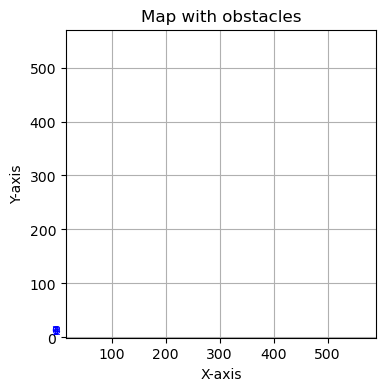

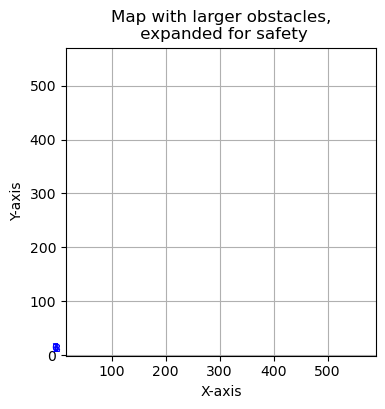

Obstacle  0
[(2.8, 1.8), (2.8, 3.2), (4.2, 3.2), (4.2, 1.8)]
Obstacle  1
[(0.8, 1.1527864045000422), (0.8, 4.2), (2.323606797749979, 4.2)]
Nodes, grouped by start-obs1-obs2-...-goal, are : 
[[0], [1, 2, 3, 4], [5, 6, 7], [8]]


Associated vertices are : 
( 0.0 , 0.0 )
( 2.8 , 1.8 )
( 2.8 , 3.2 )
( 4.2 , 3.2 )
( 4.2 , 1.8 )
( 0.8 , 1.15 )
( 0.8 , 4.2 )
( 2.32 , 4.2 )
( 2.12 , 5.12 )


Sides of obstacles are : 
Obstacle  0
[(1, 2), (2, 3), (3, 4), (4, 1)]
Obstacle  1
[(5, 6), (6, 7), (7, 5)]
0 [1, 2, 4, 5, 6]
1 [0, 4, 2, 5, 7]
2 [0, 1, 3, 5, 7, 8]
3 [2, 4, 7, 8]
4 [0, 3, 1, 5]
5 [0, 1, 2, 4, 7, 6]
6 [0, 5, 7, 8]
7 [1, 2, 3, 6, 5, 8]
8 [2, 3, 6, 7]


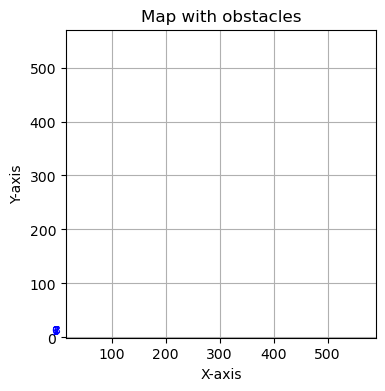

[0, 1, 2, 3, 4, 5, 6, 7, 8]


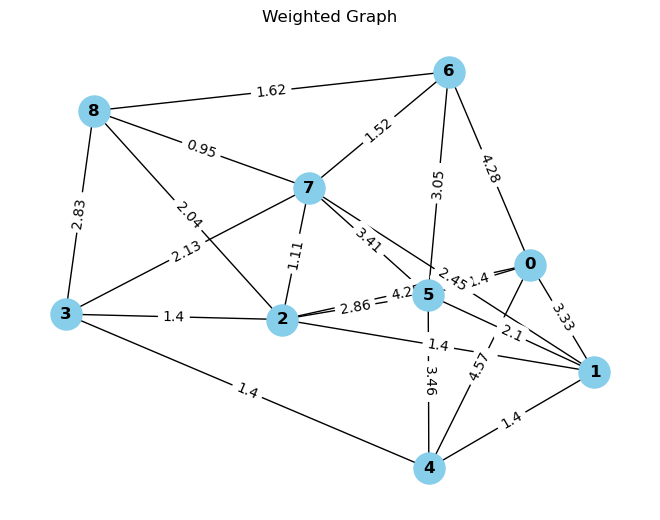

Path nodes : [0, 5, 7, 8] 
Path cost : 5.760000000000001
[[0.0, 0.0], [0.8, 1.1527864045000422], [2.323606797749979, 4.2]]
[1.4031808487861197, 3.4068883707497264, 0.9460812122183279] 
 [-55.240484662000824, -8.194464160921193, -38.68305158201961]


([1.4031808487861197, 3.4068883707497264, 0.9460812122183279],
 [-55.240484662000824, -8.194464160921193, -38.68305158201961])

In [4]:
findPath(obs_list, start_pos, robot_dir0, goal_pos, width)

In [5]:
# Representing start and goal by middle point
start_point = tuple([sum([row[0] for row in start_pos])/len(start_pos), sum([row[1] for row in start_pos])/len(start_pos)])
goal_point = tuple([sum([row[0] for row in goal_pos])/len(goal_pos), sum([row[1] for row in goal_pos])/len(goal_pos)])

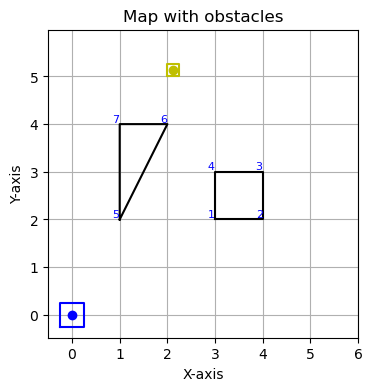

In [6]:
# Plot the map with obstacles
plot_map(obs_list, 6, 6, start=start_pos, goal=goal_pos)

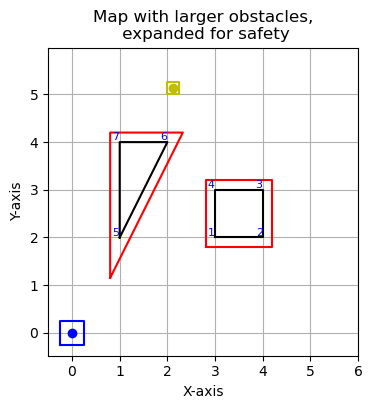

Obstacle  0
[(2.8, 1.8), (2.8, 3.2), (4.2, 3.2), (4.2, 1.8)]
Obstacle  1
[(0.8, 1.1527864045000422), (0.8, 4.2), (2.323606797749979, 4.2)]


In [7]:
# Expand obstacles (ideally by at least half of Thymio robot's width)
expanded_obs = expand_obstacles(obs_list, width) # expanded_obs is now a list of #obs lists of #verticesofthisobs tuples
plot_map(obs_list, 6, 6, True, expanded_obs, start=start_pos, goal=goal_pos)

for obs in range(len(expanded_obs)) :
    print('Obstacle ', obs)
    print(*[expanded_obs[obs]])

### b. Visibility graph : 
Prev : Receive a structure of obstacles and their vertices, from computer vision on images from camera.

Args : obstacles, list of lists.

Goal : Compute the graph on the map, on which we'll apply Dijkstra.

Return : visibility graph representation of the map.

In [8]:
myNodes, myVertices, mySides = get_nodes_and_sides(expanded_obs, start_point, goal_point)

print('Nodes, grouped by start-obs1-obs2-...-goal, are : ')
print(myNodes)
print('\n')

print('Associated vertices are : ')
for myVertex in myVertices :
    print('(', round(myVertex[0], 2), ',', round(myVertex[1], 2), ')')
print('\n')

#print(*myVertices)

print('Sides of obstacles are : ')
for obs in range(len(mySides)) :
    print('Obstacle ', obs)
    print(*[mySides[obs]])

Nodes, grouped by start-obs1-obs2-...-goal, are : 
[[0], [1, 2, 3, 4], [5, 6, 7], [8]]


Associated vertices are : 
( 0.0 , 0.0 )
( 2.8 , 1.8 )
( 2.8 , 3.2 )
( 4.2 , 3.2 )
( 4.2 , 1.8 )
( 0.8 , 1.15 )
( 0.8 , 4.2 )
( 2.32 , 4.2 )
( 2.12 , 5.12 )


Sides of obstacles are : 
Obstacle  0
[(1, 2), (2, 3), (3, 4), (4, 1)]
Obstacle  1
[(5, 6), (6, 7), (7, 5)]


In [8]:
myEdges, myWeights = get_edges_and_weights(myNodes, myVertices, mySides, verbose=True)

0 [1, 2, 4, 5, 6]
1 [0, 4, 2, 5, 7]
2 [0, 1, 3, 5, 7, 8]
3 [2, 4, 7, 8]
4 [0, 3, 1, 5]
5 [0, 1, 2, 4, 7, 6]
6 [0, 5, 7, 8]
7 [1, 2, 3, 6, 5, 8]
8 [2, 3, 6, 7]


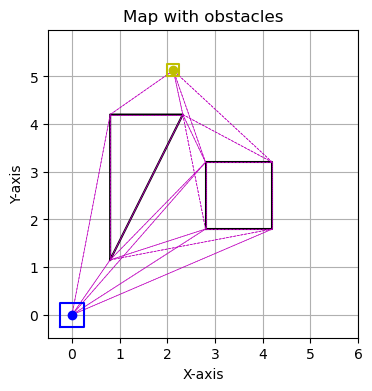

In [9]:
plot_map(expanded_obs, 6, 6, larger=False, larger_obs=None, 
         start=start_pos, goal=goal_pos, 
         graph=True, graph_edges=myEdges, vertices=myVertices)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


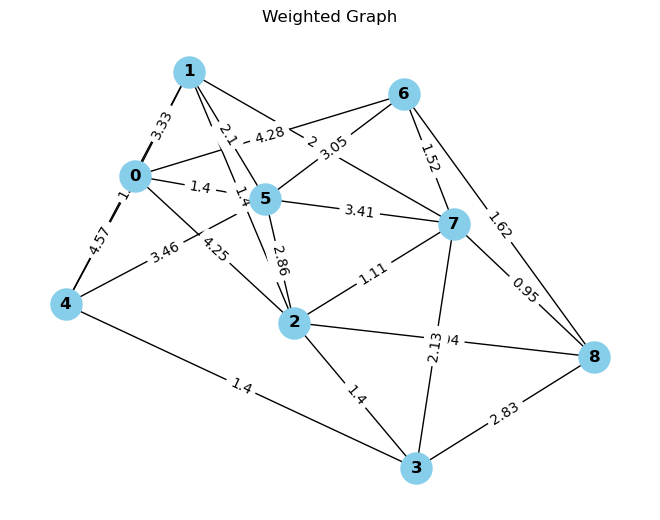

In [10]:
myGraph = create_graph(myNodes, myEdges, myWeights, verbose=True)

### c. Dijkstra algorithm, shortest path in graph :
Prev : Receive the visibility graph, with positive weights on edges.

Args : myGraph, graph with weighted edges.

Goal : Compute the best path in graph, using Dijkstra algorithm.

Return : List of vertices, forming the best path in graph (lowest cost)

In [11]:
myPath, myCost = dijkstra(myGraph, 0, 8, verbose=False)
print('Path nodes :', myPath, '\nPath cost :', myCost)

Path nodes : [0, 5, 7, 8] 
Path cost : 5.760000000000001


### d. Convertion from nodes in graph to instructions for robot :

In [15]:
# Getting coordinates of the points we want to go through
myCoordinates = get_wheretogo_coordinates(myPath, myCost, myVertices)
print(myCoordinates)

[[0.0, 0.0], [0.8, 1.1527864045000422], [2.323606797749979, 4.2]]


In [16]:
# Getting the lengths of segments of path, and the angles between them.
# Negative angle means turn to the left, positive means turn to the left (in degree).
myLengths, myAngles = get_lengths_and_angles(myPath, myCost, myVertices, robot_dir0)
print(myLengths, '\n', myAngles)

[1.4031808487861197, 3.4068883707497264, 0.9460812122183279] 
 [-55.240484662000824, -8.194464160921193, -38.68305158201961]


### Appendix : sources
- Visibility graphs : https://www.science.smith.edu/~istreinu/Teaching/Courses/274/Spring98/Projects/Philip/fp/visibility.htm
- Dijkstra algorithm on weighted graph, Github : https://gist.github.com/aeged/db5bfda411903ecd89a3ba3cb7791a05 
- ChatGPT